# Introduction

We are the Neighborhood Navigators and we have come with an answer to the long asked question of "What is the best neighborhood in Pittsburgh?". As with any good city, we feel as though the best neighborhoods are the ones that are the easiest to commit arson in. 

### The Metric

In order to figure out which neighborhood would be ideal for someone to commit arson, we first had to figure out what would be ideal in an area for arson to take place in. Based off our discussions we decided that the neighborhood with the highest amount of vacant buildings, most amount of fires, and least amount of arrests would be the best place in Pittsburgh to commit arson. These areas would be the ones where fire wouldn't be out of the ordinary in the environment which would keep attention on the arson minimal, and would contain a lot of spaces to set something on fire without potential legal repurcussion.

In order to find out our metric we used the following datasets from the WPRDC.

[**Fire Incidents in City of Pittsburgh**](https://data.wprdc.org/dataset/fire-incidents-in-city-of-pittsburgh)

[**Pittsburgh Police Arrest Data**](https://data.wprdc.org/dataset/arrest-data)

[**Pennsylvania Vacant Addresses**](https://data.wprdc.org/dataset/vacant-addresses)

[**Population by Municipality**](https://data.wprdc.org/dataset/2020-census-redistricting-data-extracts/resource/fb2cb765-458c-4deb-8252-0a18d7ce9a78)


#### Fire Incidents

Finding the area in Pittsburgh with the most amount of fires would mean that the area would be more susceptible to fires in the future and it would be fairly common for fires to take place in the area, which we would want if we we're looking to commit arson and not stand out.

The dataset has all of these fires listed and categorized by things such as the type and building but I decided to group it based off the neighborhood each fire occured in.

In [17]:
import pandas as pd
import geopandas
%matplotlib inline

incidents = pd.read_csv("fire_incidents.csv")

incidents_by_neighborhood = incidents.groupby('neighborhood').size().reset_index(name='incident_type')
sorted_incidents = incidents_by_neighborhood.sort_values(by='incident_type', ascending=False)
pd.set_option('display.max_rows', None)
print(sorted_incidents.head())

                 neighborhood  incident_type
15                    Carrick            280
16  Central Business District            255
72           South Side Flats            251
77        Squirrel Hill South            247
38                  Hazelwood            238


Theses are the top 5 areas that contained the most files in the city of Pittsburgh.
1. Carrick - 280
2. Central Business District - 255
3. South Side Flats - 251
4. Squirrel Hill South - 247
5. Hazelwood - 238

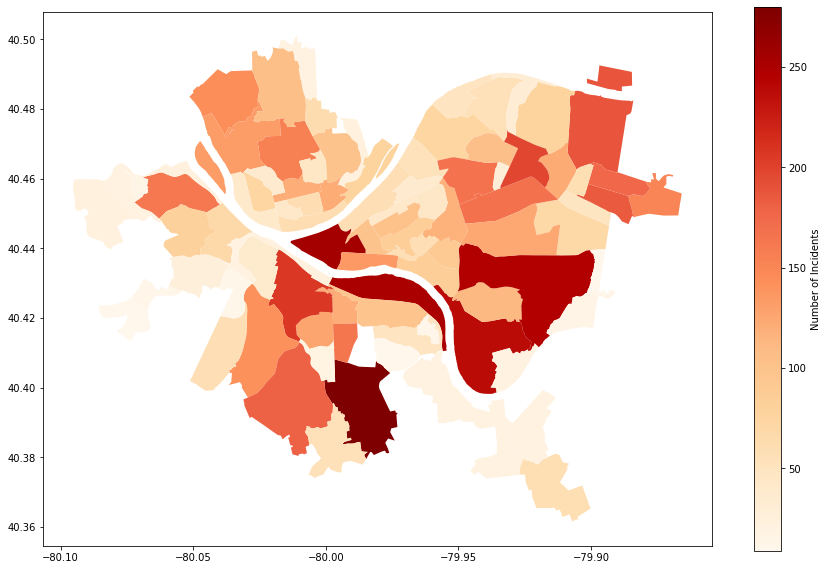

In [14]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
# plot test done to see if shapefile was read correctly
#neighborhoods.plot() 


incidents_map = neighborhoods.merge(incidents_by_neighborhood, how='left', left_on='hood', right_on='neighborhood')
incidents_map[['hood','incident_type','geometry']].head()
incidents_map.plot(column='incident_type',cmap='OrRd', legend=True, legend_kwds={'label': "Number of Incidents"}, figsize=(15, 10))

This is what the data looks like when mapped on the neighborhoods of Pittsburgh. As the map shows, Carrick and Mount Washington (which are right next to each) has the highest density of reported fires but areas such as the Central Business District of downtown and South Side Flats also have a high amount.

Personally my favorite neighborhoods are the ones that Pitt's campus resides on (so South and Central Oakland) and those are fairly far down on the list so they aren't an ideal place for us to commit arson in.

#### Arrests

For arrests, the goal was to find the neighborhood with the fewest arrests. The data would be a lot more relevant if it was narrowed down to the number of arrests per capita, so there second dataset that includes the populations of each neighborhood from the 2020 census.

In [18]:
import pandas as pd
import geopandas
%matplotlib inline

arrest = pd.read_csv("arrests.csv")
populations = pd.read_csv("censusdata.csv")

We needed to create a data structure that shows the number of arrests per capita in each neighborhood for display on a map. To achieve this, we created a dictionary that contained only the neighborhoods listed in the census and checked if the neighborhood for each arrest was in that dictionary. We then overwrote the Arrest ID with 1/ the neighborhood's population to be able to sum them up. If a neighborhood wasn't in the dictionary, we overwrote it with 0 so that entry could be removed with a mask. To improve the readability of the map, we removed three outlier neighborhoods with very high per capita arrests due to having very few residents, such as sports stadiums and casinos. I then created the map using the neighborhoods files. The grey neighborhoods are the ones that either weren't in both datasets, or I chose to exclude.

In [19]:
populationdict = {}

for index, row in populations.iterrows():
    populationdict[populations.iloc[index, 0]] = populations.iloc[index, 11]
    

In [20]:

for index, row in arrest.iterrows():
    try:
        arrest.iloc[index, 0] = 1/populationdict[arrest.loc[index, 'INCIDENTNEIGHBORHOOD']]
    except:
        arrest.iloc[index, 0] = 0
        
mask1 = arrest["PK"] != 0
arrest_capita = arrest[mask1]
mask2 = arrest_capita['INCIDENTNEIGHBORHOOD'] != "Chateau"
arrest_capita = arrest_capita[mask2]
mask3 = arrest_capita['INCIDENTNEIGHBORHOOD'] != "South Shore"
arrest_capita = arrest_capita[mask3]
mask4 = arrest_capita['INCIDENTNEIGHBORHOOD'] != "North Shore"
arrest_capita = arrest_capita[mask4]

num_arrests = arrest_capita.groupby("INCIDENTNEIGHBORHOOD").sum()['PK']
num_arrests = num_arrests.sort_values(ascending=True)

print(num_arrests[0:60])
print(num_arrests[61:82])

INCIDENTNEIGHBORHOOD
Central Northside        0.007739
Squirrel Hill North      0.022645
Swisshelm Park           0.029873
Regent Square            0.036045
North Oakland            0.038256
New Homestead            0.042530
Stanton Heights          0.047436
Squirrel Hill South      0.050336
Point Breeze             0.053665
Morningside              0.055351
Shadyside                0.058628
Westwood                 0.062725
Lincoln Place            0.065293
Banksville               0.065907
Summer Hill              0.066132
Greenfield               0.068448
Upper Lawrenceville      0.072682
Duquesne Heights         0.075511
Oakwood                  0.077073
Friendship               0.079980
Chartiers City           0.081301
Central Oakland          0.083633
Overbrook                0.084410
Highland Park            0.084844
Windgap                  0.085565
Central Lawrenceville    0.087924
Ridgemont                0.089744
Lower Lawrenceville      0.094282
Brookline                0.

In [21]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile

In [22]:

arrests_map = neighborhoods.merge(num_arrests, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

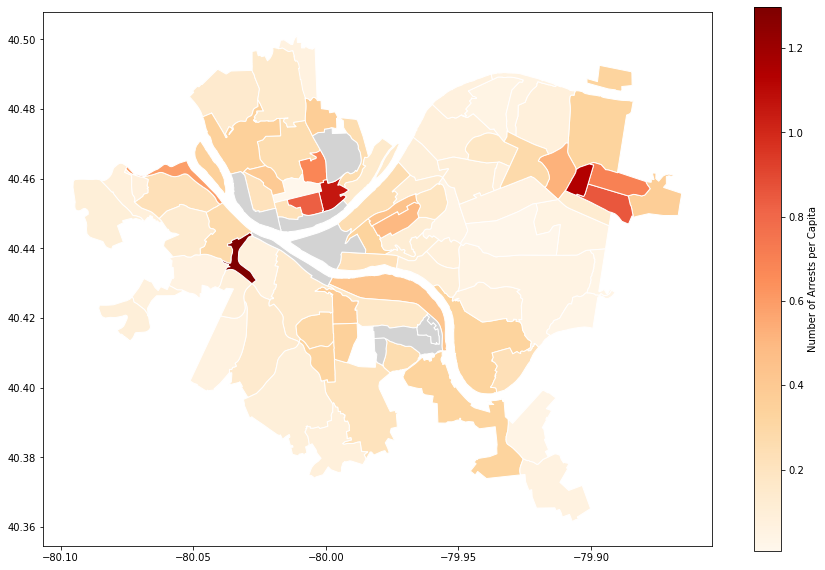

In [23]:
arrests_map.plot(column='PK', # set the data to be used for coloring
               cmap='OrRd',              # choose a color palette
               edgecolor="white",        # outline the neighborhoods in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Arrests per Capita"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "lightgrey"}) # set neighborhoods with no data to gray

As seen on the map, the 5 neighborhoods with the highest amount of vacancies are:

1. North Oakland          0.038256
2. Regent Square          0.036045
3. Swisshelm Park         0.029873
4. Squirrel Hill North    0.022645
5. Central Northside      0.007739


I'd say that North Oakland and Squirell Hill are two of my favorite neighborhoods, so i'd say that this dataset lines up fairly well with my personal favorite neighborhoods. I'm not really familiar with the other 3 neighborhoods in the lowest 5.

#### Vacancies

For vacancies our thought process was that if there is a neighborhood with a lot of empty houses, there will be less witnesseses to report to authorities. The dataset actually had vacancy rates for the entire state so I had to create a filter to only sort the data that was in the city of Pittsburgh.

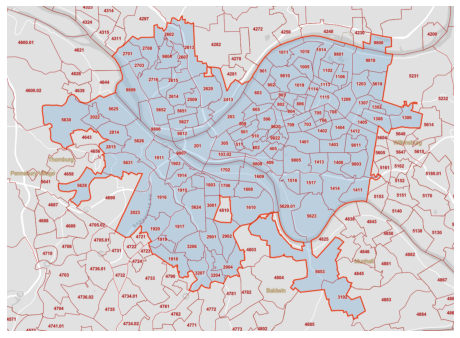

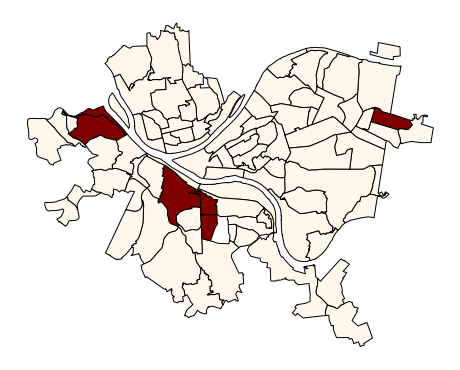

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

vacant_county = pd.read_csv("vacant.csv")
img = mpimg.imread('pittcensus.png')
fig, pittcensus = plt.subplots(figsize=(8,8))
pittcensus.imshow(img)
pittcensus.axis('off')
plt.show()

# Load the shapefile of Pittsburgh
pittsburgh = gpd.read_file("Neighborhoods/Neighborhoods_.shp")

# Create a new column that indicates which areas should be highlighted
pittsburgh['highlight'] = False
pittsburgh.loc[pittsburgh['hood'].isin(['Knoxville', 'Homewood North', 'Mount Washington', 'Allentown', 'Esplen', 'Sheraden']), 'highlight'] = True

# Plot the map with the highlighted areas
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('off')
pittsburgh.plot(column='highlight', cmap='OrRd', edgecolor='black', ax=ax)

# Show the map
plt.show()

#### Based on the two graphs, the most vacant neighborhoods in Pittsburgh are:
1. 3001 - Knoxville
2. 1302 - Homewood North
3. 1915 - Mount Washington
4. 1803 - Allentown
5. 5625 - Esplen/Sheraden

The places with the highest combination of percent and number of vacant houses would be optimal for committing arson as there will be more empty properties and less chance of being spotted. I don't have a favorite neighborhood so as long as the neighborhoods here at the univeristy are not the "best place to comit arson," I'm satisfied.

### The Best Neighborhood
##### Conclusion

Based off of our analysis, we determined that the best neighborhood to commit arson in is Mount Washington. After looking at the lists of data and creating a spreadsheet based off of the list of rankings for each of the 3 categories, Mount Washington came out as the one on top. Mount Washington had the 6th highest amount of fire incidents, the 43rd highest in fewest arrests, and the 3rd most vacant neighborhood in Pittsburgh. Compared to the averages from the other areas it was clear that Mount Washington is the best neighborhood to commit arson in.